In [9]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import re

In [10]:
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI' in tab and 'Nj1.' in tab]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab and 'Nj1.' in tab]

MItableSet = pd.DataFrame() 
for tab in MItableList:
    MItables = pd.read_csv('./EvalResults/Tables/'+tab)
    MItableSet = pd.concat([MItableSet, MItables], axis=0)


BMMItableSet = pd.DataFrame() 
for tab in BMMItableList:
    MItables = pd.read_csv('./Benchmarks/EvalResults/Tables/'+tab)
    BMMItableSet = pd.concat([BMMItableSet, MItables], axis=0)

MItableSet = pd.concat([MItableSet, BMMItableSet])

In [11]:
MItableSet['Model'].unique(), MItableSet['Metrics'].unique()

(array(['FACFC_ART_30_500', 'FACFC_ART_50_500', 'SKZFC_ART_30_500',
        'SKZFC_ART_50_500', 'SKZ_ART_30_500', 'SKZ_ART_50_500',
        'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_800',
        'FACFC_ART_50_800', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800',
        'SKZ_ART_30_800', 'SKZ_ART_50_800', 'TCMIDKZFC_ART_30_800',
        'TCMIDKZFC_ART_50_800', 'FACFC_II_30_500', 'FACFC_II_50_500',
        'SKZFC_II_30_500', 'SKZFC_II_50_500', 'SKZ_II_30_500',
        'SKZ_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500',
        'FACFC_II_30_800', 'FACFC_II_50_800', 'SKZFC_II_30_800',
        'SKZFC_II_50_800', 'SKZ_II_30_800', 'SKZ_II_50_800',
        'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'BaseVAE_ART_30',
        'BaseVAE_ART_50', 'FACVAE_ART_30', 'FACVAE_ART_50',
        'ConVAE_ART_30', 'ConVAE_ART_50', 'TCVAE_ART_30', 'TCVAE_ART_50',
        'BaseVAE_II_30', 'BaseVAE_II_50', 'FACVAE_II_30', 'FACVAE_II_50',
        'ConVAE_II_30', 'ConVAE_II_50', 'TCVAE

In [88]:
ARTTabList = ['SKZFC_ART_30_500','SKZFC_ART_30_800', 'BaseVAE_ART_30', 'ConVAE_ART_30', 'TCVAE_ART_30', 'FACVAE_ART_30',
               'SKZFC_ART_50_500','SKZFC_ART_50_800', 'BaseVAE_ART_50', 'ConVAE_ART_50', 'TCVAE_ART_50', 'FACVAE_ART_50']

IITabList = ['SKZFC_II_30_500','SKZFC_II_30_800', 'BaseVAE_II_30', 'ConVAE_II_30', 'TCVAE_II_30', 'FACVAE_II_30',
               'SKZFC_II_50_500','SKZFC_II_50_800', 'BaseVAE_II_50', 'ConVAE_II_50', 'TCVAE_II_50', 'FACVAE_II_50']

AnalMetricList = ['(1) I(V;Z)', '(2) $I(V; \\acute{Z} \\mid Z)$']


ModelRename = {}
for model in MItableSet['Model'].unique():
    if bool(re.search('_\d{3}', model)):
        ModelRename[model] = model[:-6] + model[-6:-4] +'D-Z&' +  model[-3:-2] + 's'

    else:
        ModelRename[model] =  model[:-2] + model[-2:]+'D-Z'


### Comparison with models without conditinoal input

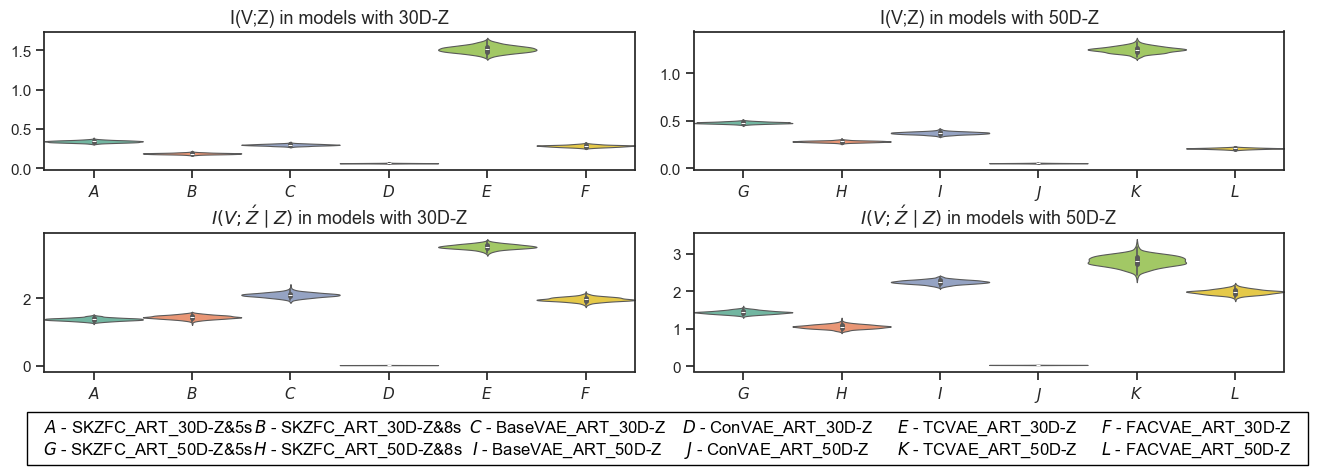

In [101]:
# Set the table list
AnalTabList = ARTTabList #IITabList, ARTTabList

if 'ART' in AnalTabList[0]:
    NZList = ['ART_30', 'ART_50']
else:
    NZList = ['II_30', 'II_50']
   
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList)) & (MItableSet['Metrics'].isin(AnalMetricList))].reset_index(drop=True)
AnalMItableSet['MetricNew'] = AnalMItableSet['Metrics'].str[4:]

sns.set(style="ticks")

metrics_categories = AnalMItableSet['MetricNew'].unique()


# Renaming models
AnalMItableSet['Model'] = AnalMItableSet['Model'].map(ModelRename)
AnalTabList = [ModelRename[item] if item in ModelRename else item for item in AnalTabList]


alphabet = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
ModelLabels = [f'${letter}$' for letter in alphabet[:len(AnalTabList)]]
DictModelLabel = {model: f'${alphabet[i]}$' for i, model in enumerate(AnalTabList)}

# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableSet = AnalMItableSet.drop(columns=['SortKey'])



global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()

total_models = len(AnalTabList)
fixed_palette = sns.color_palette("Set2", total_models)

fig, axes = plt.subplots(len(metrics_categories), 2, figsize=(16, 5))  # Increased figure size for annotation space
axes = axes.flatten()

for i, metric in enumerate(metrics_categories):
    SubsetMet = AnalMItableSet[AnalMItableSet['MetricNew'] == metric]
    
    for j, NZ in enumerate(NZList): # ['II_30', 'II_50'] ['ART_30', 'ART_50']
        ax = axes[i*2 + j]
        Subset = SubsetMet[SubsetMet['Model'].str.contains(NZ)]
        
        # Sort models alphabetically based on the labels
        unique_models_subset = sorted(Subset['Model'].unique(), key=lambda x: DictModelLabel.get(x, ''))
        
        NumModels = len(unique_models_subset)
        
        sns.violinplot(x='Model', y='Values', hue='Model', data=Subset, inner='box',
                       ax=ax, palette=fixed_palette[:NumModels], legend=False,
                       linewidth=.8, width=1., order=unique_models_subset)
        ax.set_title(metric + ' in models with ' + NZ[-2:] + 'D-Z', fontsize=13)
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_xticks(range(NumModels))
        ax.set_xticklabels([DictModelLabel[model] for model in unique_models_subset])

# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.1, hspace=0.45)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

# Determine positions for two rows and six columns
positions = []
for i in range(2):  # Two rows
    for j in range(6):  # Six columns
        x = 0.19 + j * 0.131  # Adjust horizontal spacing and starting position as needed
        y = 0.08 - i * 0.045  # Adjust vertical spacing and starting position as needed
        positions.append((x, y))

# Create text objects for each annotation
textobjs = [fig.text(x, y, f"{label} - {model}", ha='center', color='black',  fontsize=12,transform=fig.transFigure)
            for (x, y), (model, label) in zip(positions, sorted_labels)]

fig.canvas.draw()

# Calculate the bounding box for all text objects
xmin = min([t.get_window_extent().xmin for t in textobjs])
xmax = max([t.get_window_extent().xmax for t in textobjs])
ymin = min([t.get_window_extent().ymin for t in textobjs])
ymax = max([t.get_window_extent().ymax for t in textobjs])

# Convert coordinates to figure space
xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

# Add padding
padding = 0.01
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

# Create and add the rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='black', facecolor='none', transform=fig.transFigure)
fig.patches.extend([rect])

'''
if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II.png', bbox_inches='tight')
'''
plt.show()



In [8]:
AnalMItableEval =  AnalMItableSet[['Model','MetricNew', 'Values']].groupby(['Model','MetricNew']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval

,Model,MetricNew,Values
0,SKZFC_II_30_500,I(V;Z),1.221394
1,SKZFC_II_30_500,$I(V; \acute{Z} \mid Z)$,0.262626
2,SKZFC_II_30_800,I(V;Z),1.545430
3,SKZFC_II_30_800,$I(V; \acute{Z} \mid Z)$,0.538636
4,BaseVAE_II_30,$I(V; \acute{Z} \mid Z)$,1.391782
5,BaseVAE_II_30,I(V;Z),0.490869
6,ConVAE_II_30,$I(V; \acute{Z} \mid Z)$,0.061814
7,ConVAE_II_30,I(V;Z),0.108521
8,TCVAE_II_30,$I(V; \acute{Z} \mid Z)$,0.854323
9,TCVAE_II_30,I(V;Z),1.741579


In [9]:
TabList_ART_500 = ['SKZ_ART_30_500','SKZ_ART_50_500', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_500', 'SKZFC_ART_50_500', 'TCMIDKZFC_ART_30_500', 'TCMIDKZFC_ART_50_500', 'FACFC_ART_30_500', 'FACFC_ART_50_500']
TabList_ART_800 = ['SKZ_ART_30_800','SKZ_ART_50_800', 'ConVAE_ART_30', 'ConVAE_ART_50', 'SKZFC_ART_30_800', 'SKZFC_ART_50_800', 'TCMIDKZFC_ART_30_800', 'TCMIDKZFC_ART_50_800', 'FACFC_ART_30_800', 'FACFC_ART_50_800']

TabList_II_500 = ['SKZ_II_30_500','SKZ_II_50_500', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_500', 'SKZFC_II_50_500', 'TCMIDKZFC_II_30_500', 'TCMIDKZFC_II_50_500', 'FACFC_II_30_500', 'FACFC_II_50_500']
TabList_II_800 = ['SKZ_II_30_800','SKZ_II_50_800', 'ConVAE_II_30', 'ConVAE_II_50', 'SKZFC_II_30_800', 'SKZFC_II_50_800', 'TCMIDKZFC_II_30_800', 'TCMIDKZFC_II_50_800', 'FACFC_II_30_800', 'FACFC_II_50_800']              

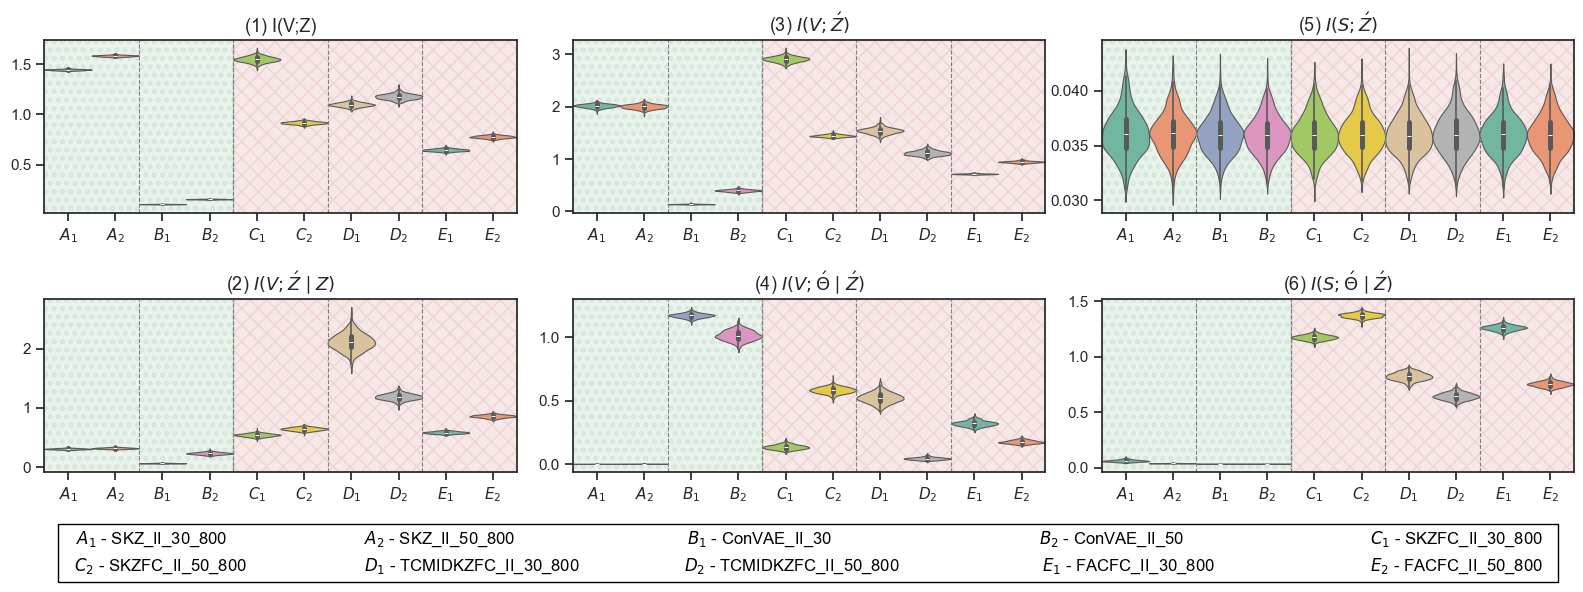

In [11]:
AnalTabList = TabList_II_800
AnalMItableSet =  MItableSet[(MItableSet['Model'].isin(AnalTabList))].reset_index(drop=True)

# Set the plot style to 'ticks' for a plain background
sns.set(style="ticks")

# Retrieve unique values from the 'Metrics' column
metrics_categories = MItableSet['Metrics'].unique()
ModelLabels = [r'$A_{1}$', r'$A_{2}$', r'$B_{1}$', r'$B_{2}$', r'$C_{1}$', r'$C_{2}$', r'$D_{1}$', r'$D_{2}$', r'$E_{1}$', r'$E_{2}$']
DictModelLabel = {model: f"{ModelLabels[i]}" for i, model in enumerate(AnalTabList)}


# Create a sorting key by mapping the 'Model' column through the DictModelLabel
AnalMItableSet['SortKey'] = AnalMItableSet['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableSet = AnalMItableSet.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableSet = AnalMItableSet.drop(columns=['SortKey'])


# Find the global minimum and maximum of the 'Values' column from the entire dataset
global_min = AnalMItableSet['Values'].min()
global_max = AnalMItableSet['Values'].max()

# Create a 3x2 subplot structure
fig, axes = plt.subplots(2, 3, figsize=(16, 6))
axes = axes.flatten(order='F')

# Generate violin plots for each 'Metrics'
for ax, metric in zip(axes, metrics_categories):
    subset = AnalMItableSet[AnalMItableSet['Metrics'] == metric]
    
    # Assign different colors for each Metrics category
    unique_models = subset['Model'].nunique()
    palette = sns.color_palette("Set2", unique_models)

    # Add vertical dashed lines at specified positions based on the length of ModelLabels
    for line_pos in [1.5, 3.5, 5.5, 7.5]:
        ax.axvline(x=line_pos, color='grey', linestyle='--', linewidth=0.8)
        ax.axvspan(-0.5, 3.5, facecolor='g', alpha=0.03, hatch='oo', edgecolor='g')
        ax.axvspan(3.5, 9.5, facecolor='r', alpha=0.03, hatch='xx', edgecolor='r')
        
    sns.violinplot(x='Model', y='Values', hue='Model', data=subset, inner='box',
                   ax=ax, palette=palette, legend=False,
                   linewidth=.8, width=1.)
    
    ax.set_title(metric, fontsize=13)  # Set title for each subplot
    ax.set_xlabel('')  # Clear the x-axis label
    ax.set_ylabel('')  # Clear the y-axis label
    ax.set_xticks(range(unique_models))  # Set the position of ticks on the x-axis
    ax.set_xticklabels(ModelLabels[:unique_models])  # Set the labels for the x-axis ticks



plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.5)

# Prepare and sort labels
sorted_labels = sorted(DictModelLabel.items(), key=lambda x: x[1])

# Determine positions for annotations
num_labels = len(ModelLabels)
# Determine positions for two rows and six columns

positions = []
'''
for i in range(1):  # 1 rows
    for j in range(8):  # eight columns for i,
        x = 0.1 + j * 0.2   # Adjust horizontal spacing and starting position as needed
        y = 0.08 - i * 0.05  # Adjust vertical spacing and starting position as needed
        positions.append((x, y))
'''
positions.append((0.10, 0.08)) # SKZ_ART_30_500'
positions.append((0.28, 0.08)) # SKZ_ART_50_500
positions.append((0.48, 0.08)) # ConVAE_ART_30
positions.append((0.7, 0.08)) # ConVAE_ART_50
positions.append((0.915, 0.08)) # SKZFC_ART_30_500

positions.append((0.105, 0.035)) # SKZFC_ART_50_500
positions.append((0.30, 0.035)) # TCMIDKZFC_ART_30_500
positions.append((0.5, 0.035)) # TCMIDKZFC_ART_50_500
positions.append((0.71, 0.035)) # FACFC_ART_30_500
positions.append((0.915, 0.035)) # FACFC_ART_50_500


# Create text objects for each annotation
textobjs = [fig.text(x, y, f"{label} - {model}", ha='center', color='black',  fontsize=12,transform=fig.transFigure)
            for (x, y), (model, label) in zip(positions, sorted_labels)]


# Draw the figure to update text positions
fig.canvas.draw()

# Calculate the bounding box for all text objects
xmin = min([t.get_window_extent().xmin for t in textobjs])
xmax = max([t.get_window_extent().xmax for t in textobjs])
ymin = min([t.get_window_extent().ymin for t in textobjs])
ymax = max([t.get_window_extent().ymax for t in textobjs])

# Convert coordinates to figure space
xmin, ymin = fig.transFigure.inverted().transform((xmin, ymin))
xmax, ymax = fig.transFigure.inverted().transform((xmax, ymax))

# Add padding
padding = 0.01
xmin -= padding
ymin -= padding
xmax += padding
ymax += padding

# Create and add the rectangle patch
rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='black', facecolor='none', transform=fig.transFigure)
fig.patches.extend([rect])

'''
CompLen = AnalMItableSet['Model'][0][-3:]
if 'ART' in AnalMItableSet['Model'][0]:
    plt.savefig('./EvalResults/Figures/VP_ART'+CompLen+'_ABL.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/VP_II'+CompLen+'_ABL.png', bbox_inches='tight')
'''
# Display the plot
plt.show()

In [12]:
AnalMItableEval =  AnalMItableSet.groupby(['Model','Metrics']).mean().reset_index().copy()
AnalMItableEval['SortKey'] = AnalMItableEval['Model'].map(DictModelLabel)
# Sort the DataFrame based on the sorting key
AnalMItableEval = AnalMItableEval.sort_values(by='SortKey').reset_index(drop=True)
# Now you can drop the 'SortKey' column if you don't need it anymore
AnalMItableEval = AnalMItableEval.drop(columns=['SortKey'])
AnalMItableEval

,Model,Metrics,Values
0,SKZ_II_30_800,(1) I(V;Z),1.442042
1,SKZ_II_30_800,(2) $I(V; \acute{Z} \mid Z)$,0.304264
2,SKZ_II_30_800,(3) $I(V;\acute{Z})$,2.015811
3,SKZ_II_30_800,(4) $I(V;\acute{\Theta} \mid \acute{Z})$,0.000523
4,SKZ_II_30_800,(5) $I(S;\acute{Z})$,0.036086
5,SKZ_II_30_800,(6) $I(S;\acute{\Theta} \mid \acute{Z})$,0.063464
6,SKZ_II_50_800,(6) $I(S;\acute{\Theta} \mid \acute{Z})$,0.040935
7,SKZ_II_50_800,(1) I(V;Z),1.579967
8,SKZ_II_50_800,(2) $I(V; \acute{Z} \mid Z)$,0.316104
9,SKZ_II_50_800,(3) $I(V;\acute{Z})$,2.001357


In [84]:
TableList = os.listdir('./EvalResults/Tables/')
BMtableList = os.listdir('./Benchmarks/EvalResults/Tables/')

MItableList = [tab for tab in TableList if 'MI' in tab ]
BMMItableList = [tab for tab in BMtableList if 'MI' in tab ]

def ExtractNj(Filename):
    Match = re.search(r'Nj(\d+)\.', Filename)
    if Match:
        return int(Match.group(1))
    else:
        return None

ARTMItableSet = pd.DataFrame() 
IIMItableSet = pd.DataFrame() 

for tab in MItableList:
    Nj = ExtractNj(tab)
    MItables = pd.read_csv('./EvalResults/Tables/'+tab)
    MItables['Nj'] = Nj

    if 'ART' in tab:
        ARTMItableSet = pd.concat([ARTMItableSet, MItables], axis=0)
    elif 'II' in tab:
        IIMItableSet = pd.concat([IIMItableSet, MItables], axis=0)

SZKFC_II_MIs = IIMItableSet[IIMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()
SZKFC_ART_MIs = ARTMItableSet[ARTMItableSet['Model'].str.contains('SKZFC')].reset_index(drop=True).copy()

SZKFC_ART_MIs['ModelNj'] = SZKFC_ART_MIs['Model'].str[6:] + '_Nj'+ SZKFC_ART_MIs['Nj'].astype('str')
SZKFC_ART_MIs['Model'] =  SZKFC_ART_MIs['Model'].str[10:12] +'D-Zj&'  + SZKFC_ART_MIs['Model'].str[13:14] + 's'

#SZKFC_ART_MIs = SZKFC_ART_MIs[['ModelNj','Metrics', 'Values']].copy()

SZKFC_II_MIs['ModelNj'] = SZKFC_II_MIs['Model'].str[6:] + '_Nj'+ SZKFC_II_MIs['Nj'].astype('str')
SZKFC_II_MIs['Model'] =  SZKFC_II_MIs['Model'].str[9:11] +'D-Zj&'  + SZKFC_II_MIs['Model'].str[12:13] + 's'
#SZKFC_II_MIs = SZKFC_II_MIs[['ModelNj','Metrics', 'Values']].copy()

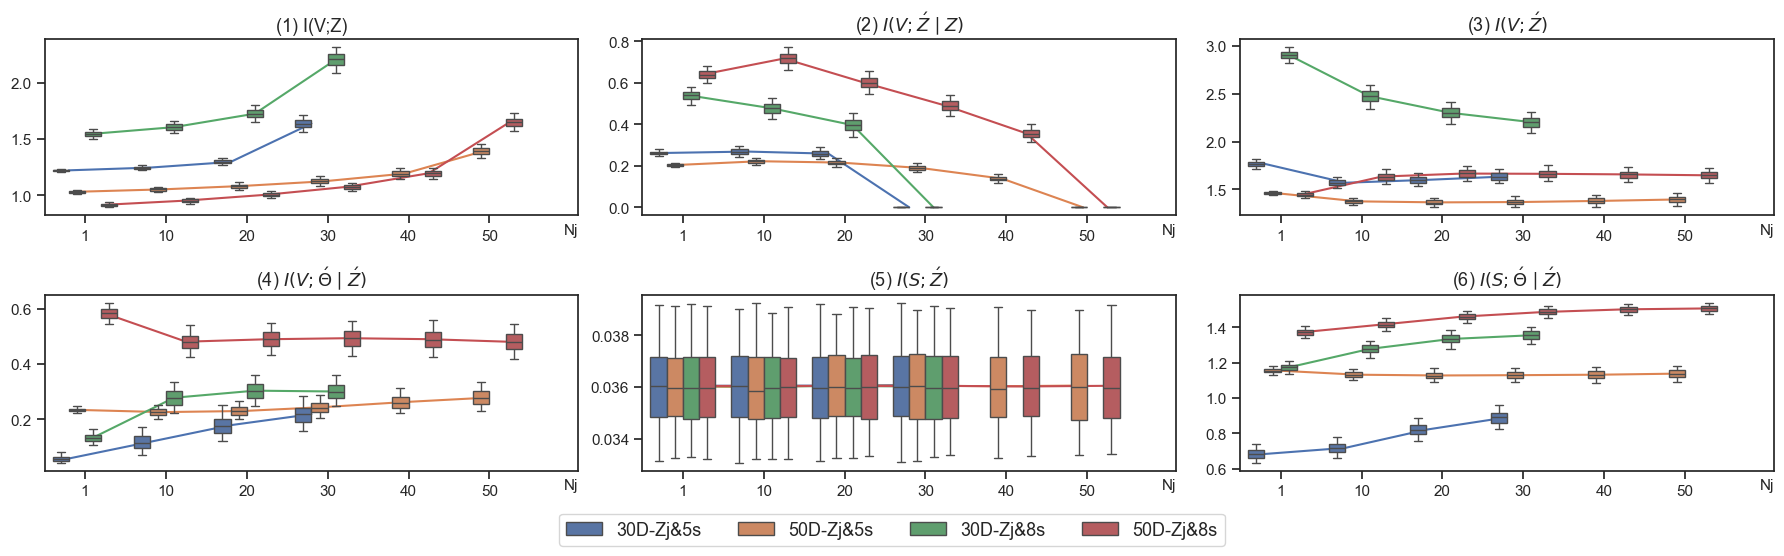

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Example assignment (replace with your actual data)
AnalMItableEval = SZKFC_II_MIs  # SZKFC_ART_MIs, SZKFC_II_MIs
SaveName = 'II'

# Calculate global y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Initialize an empty list to collect legend handles
legend_handles = []

# Iterate through unique 'Metrics'
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i // 3, i % 3]  # Determine the subplot position
    metric_data = AnalMItableEval[AnalMItableEval['Metrics'] == metric]
    
    # Get all unique 'Nj' values across all models (ensuring alignment)
    all_nj_values = metric_data['Nj'].unique()
    position_dict = {nj: pos for pos, nj in enumerate(all_nj_values)}

    # Iterate through unique 'Model'
    xmove = -0.2
    for j, model in enumerate(metric_data['Model'].unique()):
        model_data = metric_data[metric_data['Model'] == model]

        # Calculate mean for each 'Nj'
        mean_values = model_data.groupby('Nj')['Values'].mean().reindex(all_nj_values)

        # Line Plot for Central Tendency (Mean), set label to None
        ax.plot([position_dict[nj] + xmove for nj in mean_values.index], mean_values, label=None)
        xmove += 0.15

    # Overlay Box Plot and store legend info
    bplot = sns.boxplot(data=metric_data, x='Nj', y='Values', hue='Model', ax=ax, showfliers=False, whis=[5, 95])
    if i == 0:  # Only need to extract legend info once
        legend_handles = bplot.get_legend_handles_labels()[0]

    # Set the y-axis limits for each subplot to the global min and max
    #ax.set_ylim(global_min, global_max)

    # Set the title and labels for each subplot
    ax.set_title(metric, fontsize=13)
    ax.set_ylabel('')  # Replace with your actual y-label
    
    
    ax.set_xlabel('')  # Remove the default x-label
    # Extend the x-axis limits to create space for the text
    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0], xlim[1] + 0.1 * (xlim[1] - xlim[0]))
    # Set custom x-axis label at the bottom right
    ax.text(1.0, -0.12, 'Nj', ha='right', va='bottom', fontsize=11, transform=ax.transAxes)
    
    

    # Set x-ticks to the correct position and label
    ax.set_xticks(np.arange(len(all_nj_values)))
    ax.set_xticklabels(all_nj_values)

    # Remove individual subplot legends
    ax.legend().set_visible(False)

plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.45)

# Create a unified legend for the figure using the stored handles
fig.legend(handles=legend_handles, loc='lower center', ncol=len(legend_handles), bbox_to_anchor=(0.5, 0.06), fontsize=13)

if 'ART' in SaveName:
    plt.savefig('./EvalResults/Figures/BP_ART_Njs.png', bbox_inches='tight')
else:
    plt.savefig('./EvalResults/Figures/BP_II_Njs.png', bbox_inches='tight')
    
# Display the plot
plt.show()


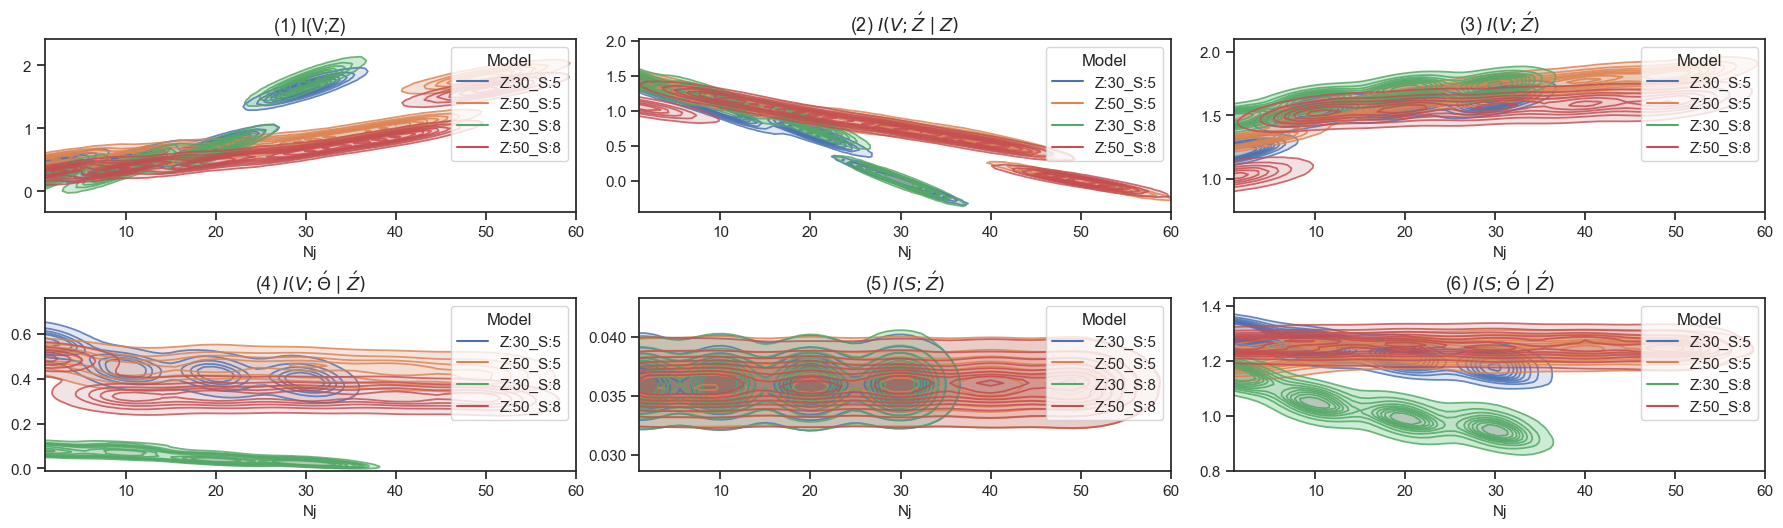

In [57]:
AnalMItableEval = SZKFC_ART_MIs #SZKFC_ART_MIs, SZKFC_II_MIs

# Create a 2x3 subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 6))

# Adjust the space between plots
plt.subplots_adjust(wspace=0.3, hspace=0.4)

# Calculate global y-axis limits
global_min = AnalMItableEval['Values'].min()
global_max = AnalMItableEval['Values'].max()

# Iterate through unique 'Metrics' and create KDE plots
for i, metric in enumerate(AnalMItableEval['Metrics'].unique()):
    ax = axes[i//3, i%3]  # Determine the subplot position
    subset = AnalMItableEval[AnalMItableEval['Metrics'] == metric]

    # Create the KDE plots
    sns.kdeplot(data=subset, y="Values", x='Nj', hue="Model", fill=True, alpha=0.4, ax=ax, gridsize=50)
    sns.kdeplot(data=subset, y="Values", x='Nj', hue="Model", fill=False, alpha=0.8, linewidths=1.3, ax=ax, gridsize=50)

    # Set the title and labels for each subplot
    ax.set_title(metric, fontsize=13)
    ax.set_ylabel("")  # Replace with your y-label
    ax.set_xlabel("Nj", fontsize=11)  # Modify as needed
    #ax.set_ylim(-0.5, 2) # Set the y-axis limits for each subplot to the global min and max
    ax.set_xlim(1, 60)
    
plt.tight_layout()
# Adjust subplot parameters to give specified padding
plt.subplots_adjust(bottom=0.2, wspace=0.12, hspace=0.5)

# Display the plot
plt.show()

In [17]:
ConfigName = 'SKZFC_ART_30_500'
# Object Load path
ObjLoadPath = './EvalResults/Instances/Obj_'+ConfigName+'_Nj'+str(NJ)+'.pkl'

# Later, when you want to restore those objects
# Create a new instance
NewEval = Evaluator()
# Populate it with the saved data
DeserializeObjects(NewEval, ObjLoadPath)

#### Selecting post Samp_Zj for generating plausible signals

In [18]:
# MetricCut: The threshold value for selecting Zs whose Entropy of PSD (i.e., SumH) is less than the MetricCut
MetricCut = 1.
PostSamp = NewEval.SelPostSamp( MetricCut)

The total number of sets in NestedZs: 19596


In [ ]:
NewEval

#### Post EvalKld_TrueGen

1/1 [==============================] - 6s 6s/step
KldPSD_GenTrue:  0.04408587873149387
KldPSD_TrueGen:  0.041194145419431644
MeanKld_GTTG:  0.04264001207546275


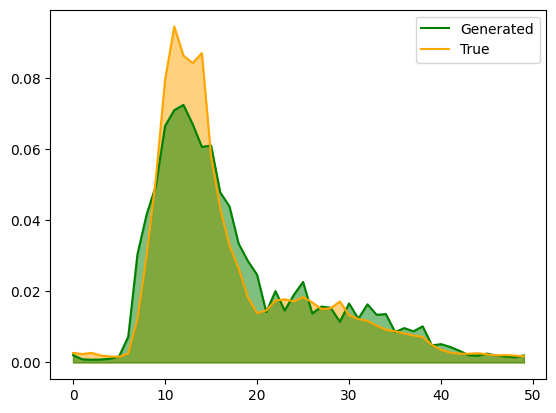

In [9]:
NewEval.GenModel = GenModel
NewEval.KLD_TrueGen(AnalSig=AnalData[:]) 

### Qualitative evaluation

#### Exploring candidates using FreqIDs

In [10]:
TrackerCandZ = NewEval.TrackerCand
BestZsMetrics = NewEval.BestZsMetrics
NewEval.CandFreqIDs
LatDim = 30

#### Visualization of signals given Z values

In [127]:
FreqID = 15
ZFixSubID = 1
SelZ =  NewEval.PostSamp[FreqID][ZFixSubID]['TrackZs']

assert ZFixSubID < len(NewEval.PostSamp[FreqID]), 'ZFixSubID must be smaller than ' + str(len(NewEval.PostSamp[FreqID]))

RecPred, HH,HL,LH, LL = VisReconGivenZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, Mode='Origin', N_Gen=300, MinFreqR=0, MaxFreqR=0.1)

NameError: name 'NewEval' is not defined

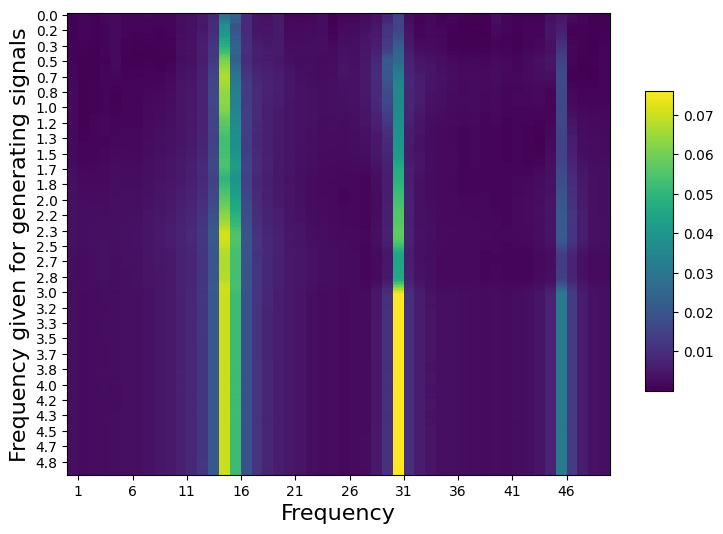

In [17]:
HeatMapFreqZ_FCA (FeatGenModel,  ReconModel, LatDim, SelZ, N_Gen=300)

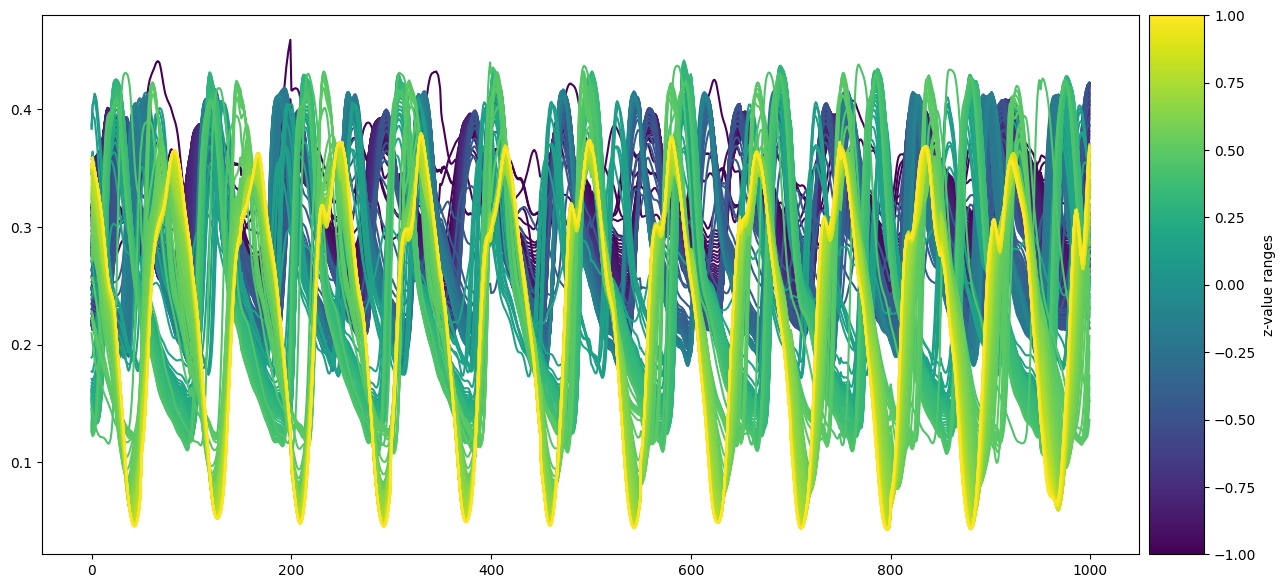

In [20]:
FcCommFix = {0: 0.05, 1: 0.05}
FcEachFix  = {0: 0.05, 1: 0.05, 2: 0.05, 3: 0.05}
RecPred, HH,HL,LH, LL = VisReconGivenFC_ZA (FeatGenModel,  ReconModel, LatDim, FcCommFix, FcEachFix,  Mode='Origin', N_Gen=300, MinZval = -1., MaxZval = 1., CutLower=-0.1, CutUpper = 0.1)

(100, 1000)


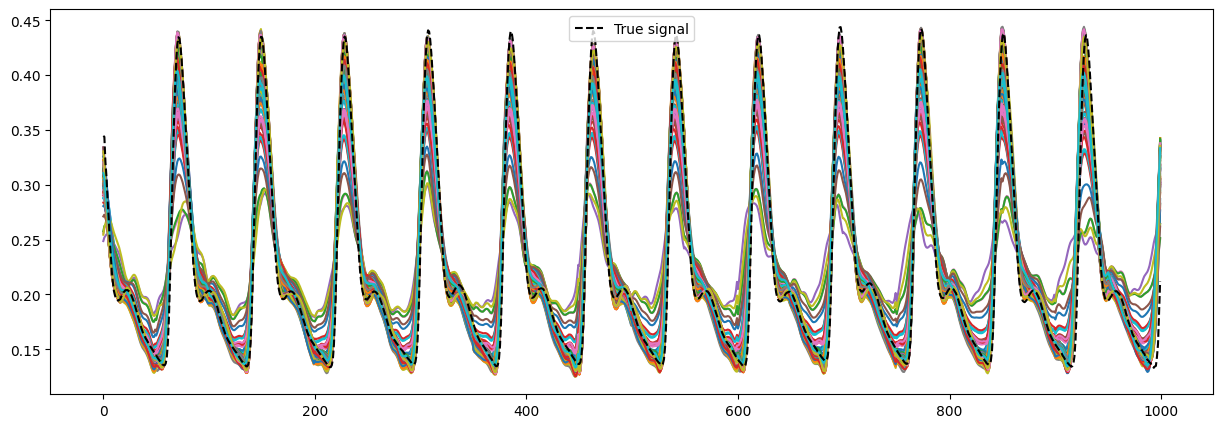

In [19]:
idx = 9871

N_Gen = 100
'''
FC_Comm = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,2))
FC_Each = np.tile(np.linspace(0.,0.05, N_Gen )[:, None], (1,4))

'''
FC_Comm = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,2))
FC_Comm = np.sort(FC_Comm)
FC_Each = np.tile(np.random.uniform(0, 0.05, N_Gen)[:, None], (1,4))
FC_Each = np.sort(FC_Each) 


RecPred, HH,HL,LH, LL = VisReconExtractZ_FC (AnalData, idx, FeatExtModel, ReconModel, FC_Comm, FC_Each, N_Gen=N_Gen)